Transformada de Fourier en Numpy
Primero veremos cómo encontrar la Transformada de Fourier usando Numpy. Numpy tiene un paquete FFT para hacer esto. np.fft.fft2() nos proporciona la transformación de frecuencia que será una matriz compleja. Su primer argumento es la imagen de entrada, que está en escala de grises. El segundo argumento es opcional y decide el tamaño de la matriz de salida. Si es mayor que el tamaño de la imagen de entrada, la imagen de entrada se rellena con ceros antes del cálculo de FFT. Si es menor que la imagen de entrada, la imagen de entrada se recortará. Si no se pasan argumentos, el tamaño de la matriz de salida será el mismo que el de entrada.

Ahora, una vez que obtenga el resultado, el componente de frecuencia cero (componente CC) estará en la esquina superior izquierda. Si desea llevarlo al centro, debe cambiar el resultado pornorte2en ambas direcciones. Esto simplemente lo hace la función np.fft.fftshift() . (Es más fácil de analizar). Una vez que haya encontrado la transformada de frecuencia, podrá encontrar el espectro de magnitud.

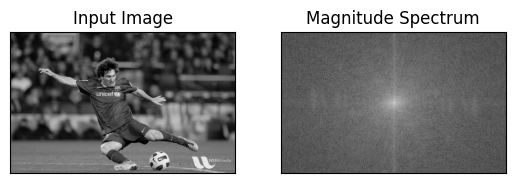

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv.imread('resources/messi5.jpg', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

Entonces encontraste la transformación de frecuencia. Ahora puedes hacer algunas operaciones en el dominio de la frecuencia, como el filtrado de paso alto y reconstruir la imagen, es decir, encontrar DFT inversa. Para ello simplemente elimina las bajas frecuencias enmascarándolas con una ventana rectangular de tamaño 60x60. Luego aplique el desplazamiento inverso usando np.fft.ifftshift() para que el componente DC vuelva a aparecer en la esquina superior izquierda. Luego encuentre la FFT inversa usando la función np.ifft2() . El resultado, nuevamente, será un número complejo. Puedes tomar su valor absoluto.

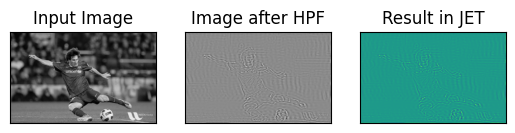

In [2]:
rows, cols = img.shape
crow, ccol = rows//2, cols//2
fshift[crow-30:crow+31, ccol-30:ccol+31] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.real(img_back)
plt.subplot(131),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(img_back)
plt.title('Result in JET'), plt.xticks([]), plt.yticks([])
plt.show()

Transformada de Fourier en OpenCV.

OpenCV proporciona las funciones cv.dft() y cv.idft() para esto. Devuelve el mismo resultado que el anterior, pero con dos canales. El primer canal tendrá la parte real del resultado y el segundo canal tendrá la parte imaginaria del resultado. La imagen de entrada debe convertirse primero a np.float32. Veremos cómo hacerlo.

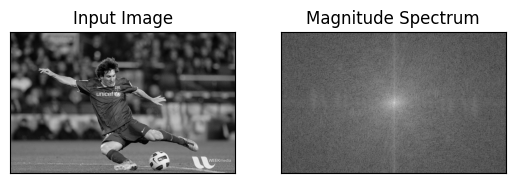

In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread('resources/messi5.jpg', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
dft = cv.dft(np.float32(img),flags = cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20*np.log(cv.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

Entonces, ahora tenemos que hacer DFT inversa. En la sesión anterior creamos un HPF, esta vez veremos cómo eliminar contenidos de alta frecuencia en la imagen, es decir, aplicamos LPF a la imagen. De hecho, desdibuja la imagen. Para esto, primero creamos una máscara con un valor alto (1) en bajas frecuencias, es decir, pasamos el contenido de LF, y 0 en la región de HF.

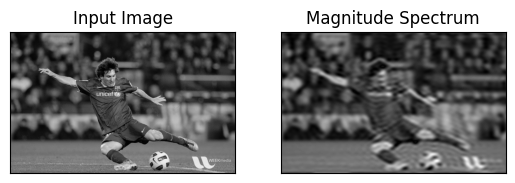

In [4]:
rows, cols = img.shape
crow, ccol = rows//2, cols//2
# create a mask first, center square is 1, remaining all zeros
mask = np.zeros((rows,cols,2),np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 1
# apply mask and inverse DFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv.idft(f_ishift)
img_back = cv.magnitude(img_back[:,:,0],img_back[:,:,1])
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

Optimización del rendimiento de DFT

El rendimiento del cálculo DFT es mejor para algunos tamaños de matriz. Es más rápido cuando el tamaño de la matriz es potencia de dos. Las matrices cuyo tamaño es producto de 2, 3 y 5 también se procesan de manera bastante eficiente. Entonces, si le preocupa el rendimiento de su código, puede modificar el tamaño de la matriz a cualquier tamaño óptimo (rellenando ceros) antes de encontrar DFT. Para OpenCV, debe rellenar ceros manualmente. Pero para Numpy, usted especifica el nuevo tamaño del cálculo FFT y automáticamente rellenará los ceros por usted.

Entonces, ¿cómo encontramos este tamaño óptimo? OpenCV proporciona una función, cv.getOptimalDFTSize() para esto. Es aplicable tanto a cv.dft() como a np.fft.fft2() . Comprobemos su rendimiento utilizando el comando mágico de IPython timeit.

In [5]:
img = cv.imread('resources/messi5.jpg', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
rows,cols = img.shape
print("{} {}".format(rows,cols))

nrows = cv.getOptimalDFTSize(rows)
ncols = cv.getOptimalDFTSize(cols)
print("{} {}".format(nrows,ncols))


342 548
360 576


Mira, el tamaño (342,548) se modifica a (360, 576). Ahora rellenémoslo con ceros (para OpenCV) y encontremos su rendimiento de cálculo DFT. Puede hacerlo creando una nueva matriz de ceros grande y copiando los datos en ella, o usando cv.copyMakeBorder() .

In [6]:
nimg = np.zeros((nrows,ncols))
nimg[:rows,:cols] = img

O

In [7]:
right = ncols - cols
bottom = nrows - rows
bordertype = cv.BORDER_CONSTANT #just to avoid line breakup in PDF file
nimg = cv.copyMakeBorder(img,0,bottom,0,right,bordertype, value = 0)

Ahora calculamos la comparación del rendimiento DFT de la función Numpy:

In [8]:
%timeit fft1 = np.fft.fft2(img)

17.4 ms ± 4.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%timeit fft2 = np.fft.fft2(img,[nrows,ncols])

7.41 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Muestra una aceleración de 4x. Ahora intentaremos lo mismo con las funciones de OpenCV.

In [10]:
%timeit dft1= cv.dft(np.float32(img),flags=cv.DFT_COMPLEX_OUTPUT)

2.44 ms ± 185 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%timeit dft2= cv.dft(np.float32(nimg),flags=cv.DFT_COMPLEX_OUTPUT)

1.25 ms ± 88.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


¿Por qué el laplaciano es un filtro de paso alto?

Se hizo una pregunta similar en un foro. La pregunta es, ¿por qué el laplaciano es un filtro de paso alto? ¿Por qué Sobel es un HPF? etc. Y la primera respuesta que se le dio fue en términos de Transformada de Fourier. Simplemente tome la transformada de Fourier del Laplaciano para obtener un tamaño mayor de FFT. Analízalo:

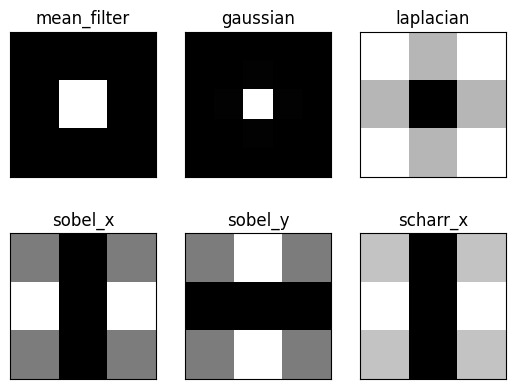

In [12]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
# simple averaging filter without scaling parameter
mean_filter = np.ones((3,3))
# creating a gaussian filter
x = cv.getGaussianKernel(5,10)
gaussian = x*x.T
# different edge detecting filters
# scharr in x-direction
scharr = np.array([[-3, 0, 3],
                   [-10,0,10],
                   [-3, 0, 3]])
# sobel in x direction
sobel_x= np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
# sobel in y direction
sobel_y= np.array([[-1,-2,-1],
                   [0, 0, 0],
                   [1, 2, 1]])
# laplacian
laplacian=np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])
filters = [mean_filter, gaussian, laplacian, sobel_x, sobel_y, scharr]
filter_name = ['mean_filter', 'gaussian','laplacian', 'sobel_x', \
                'sobel_y', 'scharr_x']
fft_filters = [np.fft.fft2(x) for x in filters]
fft_shift = [np.fft.fftshift(y) for y in fft_filters]
mag_spectrum = [np.log(np.abs(z)+1) for z in fft_shift]
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(mag_spectrum[i],cmap = 'gray')
    plt.title(filter_name[i]), plt.xticks([]), plt.yticks([])
plt.show()